# Check Second Peak Due to Attenuation?

Using the attenuation wavelength dependence theory from Refractive_index_attenuation_wavelength_dependence.ipynb, we would like to see whether the second peak in the upstream signal is a result of a convolving their waveforms with the attenuation curve. 

Method for this was fourier transforming from frequency space to time space.
   


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## SiPM Response Wavelength Dependence

1.0011078146899066


Text(0, 0.5, 'SiPM Response (au, normalised)')

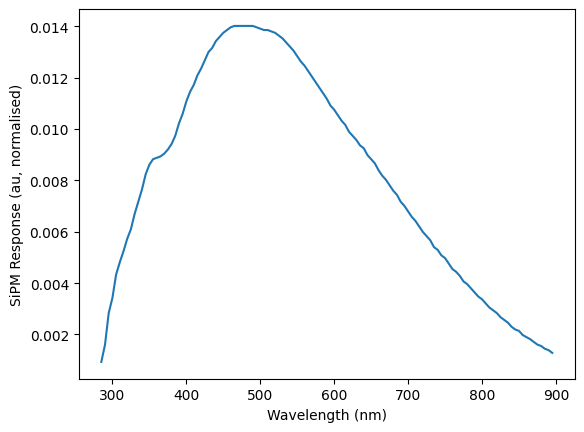

In [3]:

SiPM_response = pd.read_csv('CLEAR_14160-3010_SiPM_response.csv')
wavelengths = SiPM_response['Wavelength'].values
response = SiPM_response['Response'].values

# Normalise the SiPM response (will be important for determining the effective refractive index)

area_under_curve = np.trapezoid(response, wavelengths) / 5  # 5 is the step size in the wavelengths array, to get the area under the curve in nm

response_normalised = response / area_under_curve

print(sum(response_normalised))

# Plot normalised SiPM response

plt.plot(wavelengths, response_normalised)
plt.xlabel('Wavelength (nm)')
plt.ylabel('SiPM Response (au, normalised)')

Text(0, 0.5, 'SiPM Response (au, normalised)')

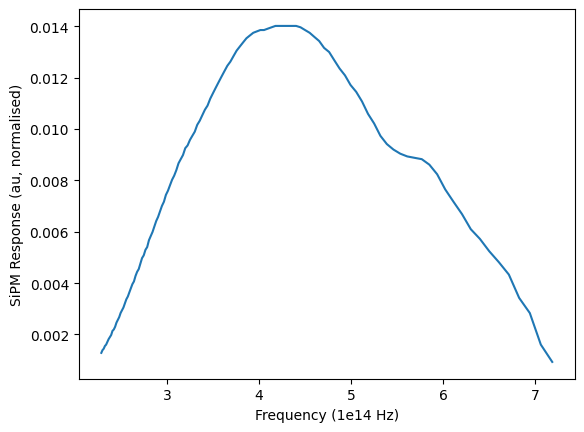

In [4]:
# Plot normalised SiPM response against frequency
refr_idx = 1.465
frequencies = 3e8 / (1.465 * (wavelengths * 1e-9))  # Convert wavelengths from nm to m for frequency calculation

plt.plot(frequencies * 1e-14, response_normalised)
plt.xlabel('Frequency (1e14 Hz)')
plt.ylabel('SiPM Response (au, normalised)')

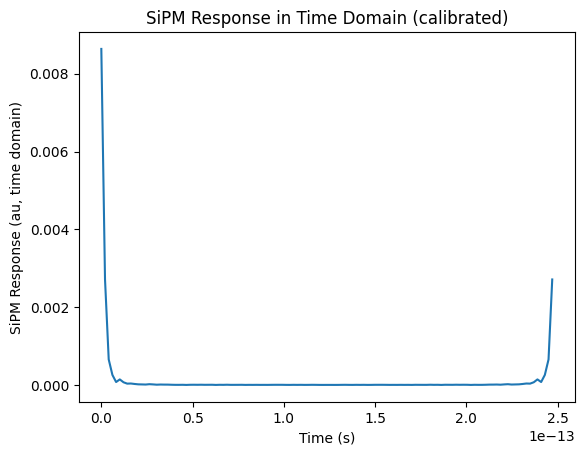

In [5]:
# Convert wavelengths (nm) to frequencies (Hz)
c = 3e8  # speed of light in m/s
n = 1.465  # refractive index
frequencies = c / (n * wavelengths * 1e-9)  # Hz

# Create an evenly spaced frequency grid
freq_min, freq_max = frequencies.min(), frequencies.max()
freq_uniform = np.linspace(freq_min, freq_max, len(frequencies))

# Interpolate the response onto the uniform frequency grid
response_freq = np.interp(freq_uniform, frequencies[::-1], response_normalised[::-1])

# Now perform the Fourier transform
response_time_domain = np.fft.ifft(response_freq)


# After your FFT code
delta_f = freq_uniform[1] - freq_uniform[0]  # Hz
N = len(freq_uniform)
time = np.arange(N) / (N * delta_f)  # seconds

plt.figure()
plt.plot(time, np.abs(response_time_domain))
plt.xlabel('Time (s)')
plt.ylabel('SiPM Response (au, time domain)')
plt.title('SiPM Response in Time Domain (calibrated)')
plt.show()

In [6]:
#fiber_lengths = [0, 1, 4, 25, 75, 100, 200, 300]
fiber_lengths = np.arange(0, 150, 20) # in m (CLEAR oBLM fiber is 130m long)
# wavelengths = np.arange(285, 900, 1) # in nm

## Attenuation factor
Equation (3.16)

In [7]:
# attenuation factor
attenuations = np.zeros((len(fiber_lengths), len(wavelengths)))
for i in range(len(fiber_lengths)):
    attenuations[i, :] = 10 ** ((-0.83 * fiber_lengths[i]) / (10 * (wavelengths * 1e-9) ** 4 * (10 ** 27))) 


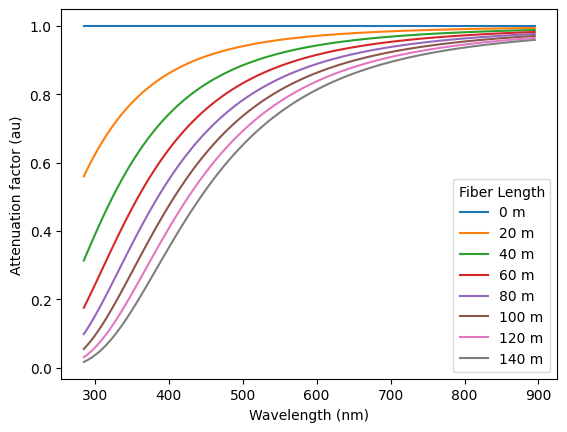

In [8]:
import matplotlib.pyplot as plt

for i, length in enumerate(fiber_lengths):
    plt.plot(wavelengths, attenuations[i, :], label=f'{length} m')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Attenuation factor (au)')
plt.legend(title='Fiber Length')
plt.show()

## Number of cherenkov photons as function of wavelength
Equation 3.6,
Equation 3.12,
Not including attenuation or SiPM response


In [9]:
# All property values taken from Sara's thesis.

beta = 1 # particles travel at approximately the speed of light
refr_core = 1.46 # refractive index of the fiber core
num_aperture = 0.22 # numerical aperture
fine_struct = 1/137 # fine structure constant
z = 1 # charge of the particle
cherenkov_angle = np.arccos(beta / refr_core) # cherenkov angle in radians


In [10]:
# total number of photons generated having travelled a path length of x and at a certain wavelength

N_diff = 2 * np.pi * fine_struct * z**2 * np.sin(cherenkov_angle)**2 / (wavelengths * 1e-9)**2

# Calculate the capture factor F_cap: ie. the probability of photons being transmitted through the fiber and able to exit out the end of the fiber 
# nb, I'm using the maximum capture angle which occurs when the particle hits the fiber at the cherenkov angle.

F_cap = 1/np.pi *  np.arccos((beta * np.sqrt(refr_core ** 2 - num_aperture ** 2) - np.cos(cherenkov_angle))/(np.sin(cherenkov_angle)*np.sqrt(beta**2 * refr_core**2 - 1)))



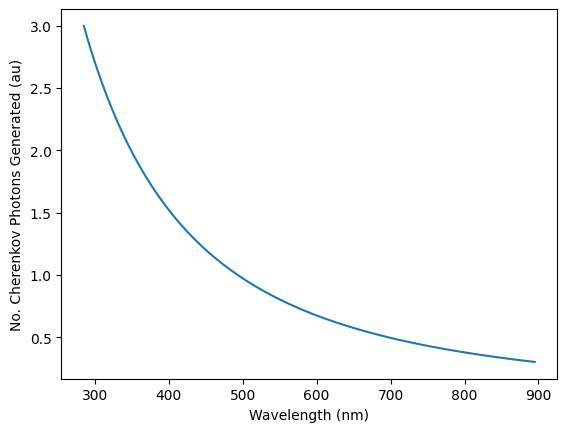

In [11]:
# Plot number of cherenkov photons generated as a function of wavelength

plt.plot(wavelengths, N_diff * 1e-11)

plt.xlabel('Wavelength (nm)')
plt.ylabel('No. Cherenkov Photons Generated (au)')
plt.show()

## Total number of photons measured at end of fiber (including attenuation and SiPM response)
Equation 3.17

In [12]:
# total number of Cherenkov photons that will be measured at the end of the fiber N_SiPM    

N_SiPM = N_diff * F_cap * attenuations * response_normalised

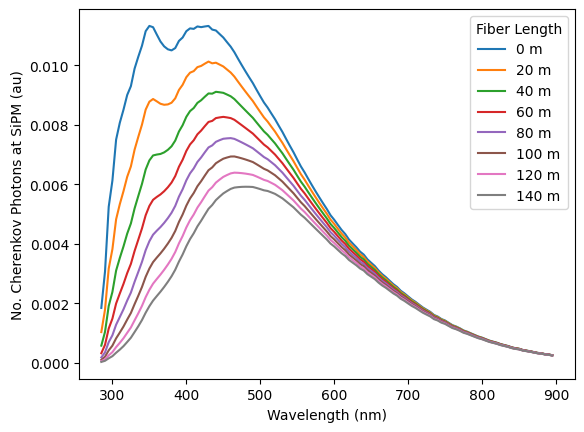

In [29]:
# Plot the total number of photons measured at the end of the fiber for different fiber lengths

for i, length in enumerate(fiber_lengths):
    plt.plot(wavelengths, N_SiPM[i, :] * 1e-10, label=f'{length} m')

plt.xlabel('Wavelength (nm)')
plt.ylabel('No. Cherenkov Photons at SiPM (au)')
plt.legend(title='Fiber Length')
plt.show()

/var/folders/9b/rflmj6b95v580hlcrfgj5vsh0000gn/T/ipykernel_1917/248998361.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  response_time_domain[:, i] = np.fft.ifft(response_freq[:, i])


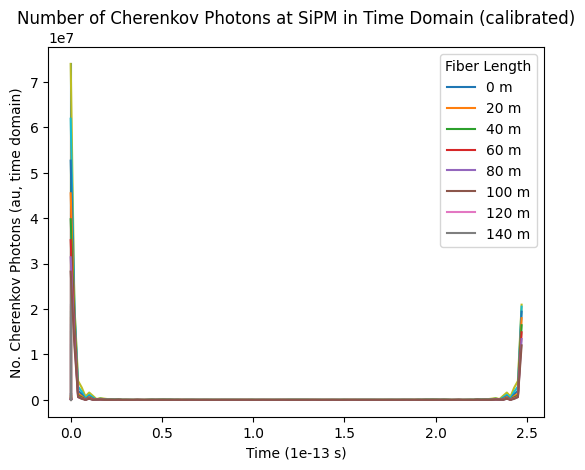

In [39]:
# Convert wavelengths (nm) to frequencies (Hz)
c = 3e8  # speed of light in m/s
n = 1.465  # refractive index
frequencies = c / (n * wavelengths * 1e-9)  # Hz

# Create an evenly spaced frequency grid
freq_min, freq_max = frequencies.min(), frequencies.max()
freq_uniform = np.linspace(freq_min, freq_max, len(frequencies))

response_freq = np.zeros((len(frequencies), len(fiber_lengths)))
response_time_domain = np.zeros((len(frequencies), len(fiber_lengths)))

for i, length in enumerate(fiber_lengths):
    # Interpolate the response onto the uniform frequency grid
    response_freq[:, i] = np.interp(freq_uniform, frequencies[::-1], N_SiPM[i, ::-1])
    # Now perform the Fourier transform
    response_time_domain[:, i] = np.fft.ifft(response_freq[:, i])


# After your FFT code
delta_f = freq_uniform[1] - freq_uniform[0]  # Hz
N = len(freq_uniform)
time = np.arange(N) / (N * delta_f)  # seconds

for i, length in enumerate(fiber_lengths):
    plt.plot(time, np.abs(response_time_domain[:, i]), label=f'{length} m')


plt.legend(title='Fiber Length')
plt.plot(time * 1e13, np.abs(response_time_domain))
plt.xlabel('Time (1e-13 s)')
plt.ylabel('No. Cherenkov Photons (au, time domain)')
plt.title('Number of Cherenkov Photons at SiPM in Time Domain (calibrated)')
# plt.xlim(0, 0.5)
plt.show()

### Normalise the number of photons to the area under the curve for each fiber length

1.0007903246103558


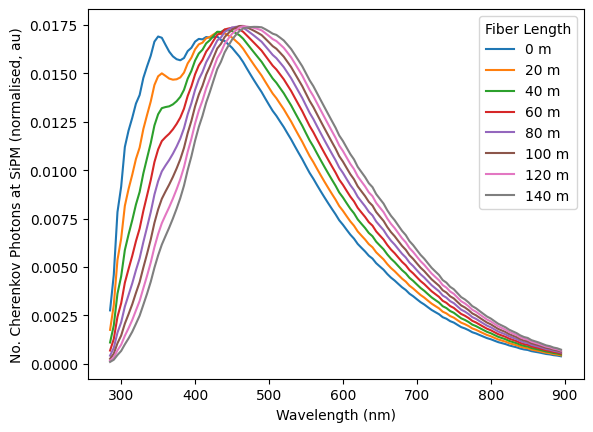

In [ ]:
# Normalise the number of cherenkov photons (will be important for determining the effective refractive index)

area_under_curve = np.trapezoid(N_SiPM, wavelengths, axis=1) / 5 # 5 is the step size in the wavelengths array, to get the area under the curve in nm

N_SiPM_normalised = np.zeros_like(N_SiPM)
for i in range(len(fiber_lengths)):
    N_SiPM_normalised[i,:] = N_SiPM[i,:] / area_under_curve[i]


check = sum(N_SiPM_normalised[2,:])  # Check that the normalisation is correct
print(check)
# Plot normalised number of cherenkov photons detected at SiPM for each fiber length

for i, length in enumerate(fiber_lengths):
    plt.plot(wavelengths, N_SiPM_normalised[i, :], label=f'{length} m')

plt.xlabel('Wavelength (nm)')
plt.ylabel('No. Cherenkov Photons at SiPM (normalised, au)')
plt.legend(title='Fiber Length')
plt.show()


## Refractive index of silica against wavelength 
From https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson 

In [ ]:
# Conversion index between wavelength and refractive index of a silica fiber

wavelengths_um = wavelengths * 1e-3  # Convert nm to um
refr_idx = np.sqrt((0.6961663 * wavelengths_um ** 2) / (wavelengths_um ** 2 - 0.0684043 ** 2)  + (0.4079426 * wavelengths_um ** 2) / (wavelengths_um **2 - 0.1162414 ** 2) + (0.8974794 * wavelengths_um **2) / (wavelengths_um ** 2 - 9.896161 ** 2) + 1)

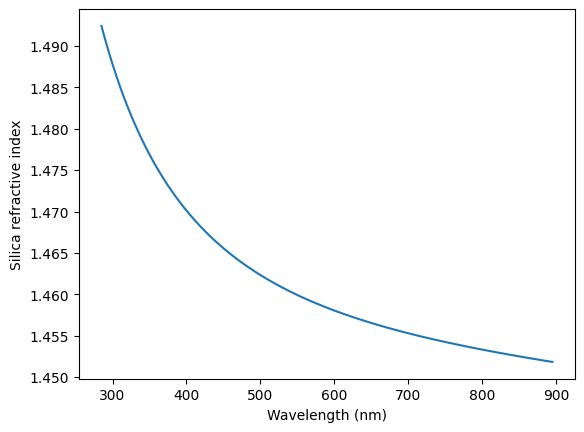

In [ ]:
# Plot the total number of photons measured at the end of the fiber for different fiber lengths

import matplotlib.pyplot as plt

plt.plot(wavelengths, refr_idx)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Silica refractive index')
plt.show()

## Effective refractive index against distance

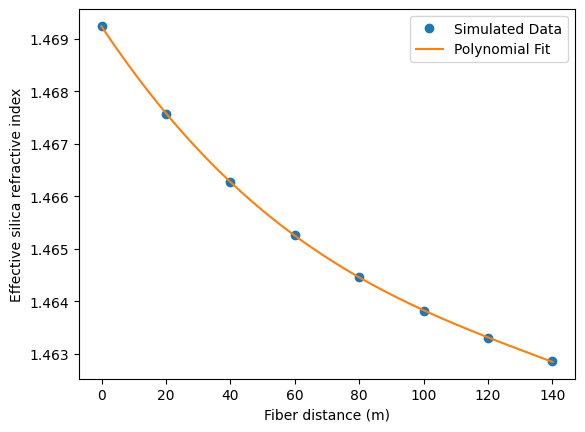

array([-1.22850073e-09,  5.05237755e-07, -9.22909293e-05,  1.46923503e+00])

In [ ]:
# Integrate over the wavelengths to find the effective refractive index for different fiber distances
eff_refr_idx = np.zeros(len(fiber_lengths))


for i, length in enumerate(fiber_lengths):
    eff_refr_idx[i] = sum(np.array(N_SiPM_normalised[i, :]) * np.array(refr_idx))

plt.plot(fiber_lengths, eff_refr_idx, 'o', label = 'Simulated Data')
plt.xlabel('Fiber distance (m)')
plt.ylabel('Effective silica refractive index')

# Fit for a polynomial to find the effective refractive index as a function of fiber distance
coeffs = np.polyfit(fiber_lengths, eff_refr_idx, 3)
poly_fit = np.poly1d(coeffs)
x_fit = np.linspace(0, max(fiber_lengths), 100)

plt.plot(x_fit, poly_fit(x_fit), '-', label='Polynomial Fit')
plt.legend()
plt.show()

coeffs
